<a href="https://colab.research.google.com/github/vineethavgnair/ac_as1/blob/master/mits_fdp_experiment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U -q PyDrive

In [0]:
zip_id = '1bc1LSaIf_ZJmWuIQhp20xh8NbZig4t3K'

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile, os

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [0]:
if not os.path.exists('tmp'):
    os.makedirs('tmp')


In [13]:
# 2. Download Zip
print ("Downloading zip file")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('bin.zip')

In [14]:
# 3. Unzip
print ("Uncompressing zip file")
zip_ref = zipfile.ZipFile('bin.zip', 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

Uncompressing zip file


In [17]:
bottle_dir = os.path.join('tmp/train/Bottle')
keyboard_dir = os.path.join('tmp/train/Keyboard')


print('total training bottle images:', len(os.listdir(bottle_dir)))
print('total training keyboard images:', len(os.listdir(keyboard_dir)))


bottle_files = os.listdir(bottle_dir)
print(bottle_files[:10])

keyboard_files = os.listdir(keyboard_dir)
print(keyboard_files[:10])



total training bottle images: 15
total training keyboard images: 15
['out1.png', 'out13.png', 'out10.png', 'out14.png', 'out2.png', 'out4.png', 'out15.png', 'out9.png', 'out3.png', 'out6.png']
['out1.png', 'out13.png', 'out10.png', 'out14.png', 'out2.png', 'out4.png', 'out15.png', 'out9.png', 'out3.png', 'out6.png']


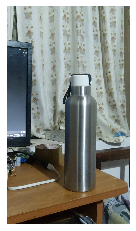

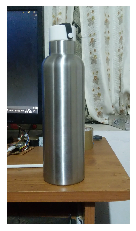

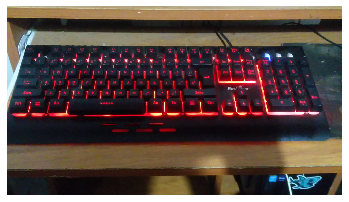

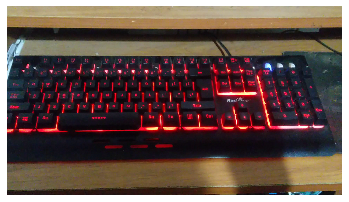

In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_bottle = [os.path.join(bottle_dir, fname) 
                for fname in bottle_files[pic_index-2:pic_index]]
next_keyboard = [os.path.join(keyboard_dir, fname) 
                for fname in keyboard_files[pic_index-2:pic_index]]


for i, img_path in enumerate(next_bottle+next_keyboard):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [19]:
# Over to test data for validation
bottle_dir = os.path.join('tmp/test/Bottle')
keyboard_dir = os.path.join('tmp/test/Keyboard')

print('total testing bottle images:', len(os.listdir(bottle_dir)))
print('total testing keyboard images:', len(os.listdir(keyboard_dir)))


bottle_files = os.listdir(bottle_dir)
print(bottle_files[:10])

keyboard_files = os.listdir(keyboard_dir)
print(keyboard_files[:10])


total testing bottle images: 5
total testing keyboard images: 5
['out17.png', 'out16.png', 'out20.png', 'out18.png', 'out19.png']
['out17.png', 'out16.png', 'out20.png', 'out18.png', 'out19.png']


In [20]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [21]:
TRAINING_DIR = "tmp/train/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/test/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

Found 30 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 149, 149, 64)      832       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 73, 73, 64)        16448     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 35, 35, 128)       32896     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)      

In [42]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)

model.save("model.h5")

Epoch 1/25
Epoch 1/25
1/1 [==============================] - 10s 10s/step - loss: 0.6905 - acc: 0.5000 - val_loss: 0.9717 - val_acc: 0.5000
Epoch 2/25
Epoch 1/25
1/1 [==============================] - 1s 958ms/step - loss: 1.0019 - acc: 0.5000 - val_loss: 6.7857 - val_acc: 0.5000
Epoch 3/25
Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 7.0028 - acc: 0.5000 - val_loss: 0.6997 - val_acc: 0.5000
Epoch 4/25
Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 0.7314 - acc: 0.5000 - val_loss: 0.6327 - val_acc: 0.5000
Epoch 5/25
Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 0.6602 - acc: 0.5000 - val_loss: 0.5489 - val_acc: 0.5000
Epoch 6/25
Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 0.5828 - acc: 0.5000 - val_loss: 0.4600 - val_acc: 0.5000
Epoch 7/25
Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 0.4729 - acc: 0.5000 - val_loss: 0.4700 - val_acc: 1.0000
Epoch 8/25
Epoch 1/25
1/1 [==

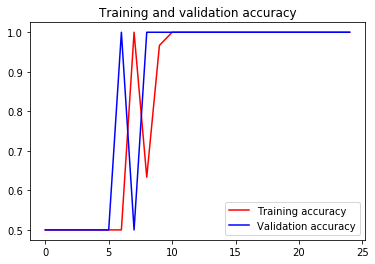

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()



In [51]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

Saving images (4).jpg to images (4).jpg
images (4).jpg
[[0. 1.]]
